In [1]:
import sys
import os

# Add ROOT/model path to load own modules
model_path = os.path.normpath(os.path.join(os.getcwd(), *[os.pardir]*2, "model"))
sys.path.insert(0, model_path)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Lambda, InputLayer
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from kerastuner.tuners import RandomSearch
from tensorflow.keras import metrics
from keras.callbacks import TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
# from keras import metrics
import pandas as pd
# from reproduce import reproduce
import numpy as np
# from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
from utils import get_data, plot_predicted_vs_true, custom_r2, custom_adj_r2, ROOT_DIR
from datetime import datetime
from shutil import rmtree
import os
import sys

%load_ext autoreload
%autoreload 2

In [3]:
'''
TRAINING = True
CLEAN = False

if len(sys.argv) > 1:
    if sys.argv[1] == "train":
        TRAINING = True
    if sys.argv[1] == "clean":
        CLEAN = True
'''

'\nTRAINING = True\nCLEAN = False\n\nif len(sys.argv) > 1:\n    if sys.argv[1] == "train":\n        TRAINING = True\n    if sys.argv[1] == "clean":\n        CLEAN = True\n'

In [4]:
begin = datetime.now()
# This set seeds to make the result reproducible
# reproduce(0)


#tensorboard = TensorBoard(log_dir=ROOT_DIR + "/logs/")

# read in data using pandas

X_train, Y_train, X_validation, Y_validation, X_test, Y_test = get_data()

# get number of columns in training data
#validation_split_rate = 0.2
#n_units_of_N_layer = 128
n_cols = X_train.shape[1]
#train_total = X_train.shape[0]
#batch_size = int(np.floor((1 - validation_split_rate) * train_total))

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(n_cols,)))

    num_units_per_layer = hp.Int('units_per_hidden_layer', min_value=32,
                                 max_value=4096, step=32)
    dropout_rate_per_layer = hp.Float('dropout_per_hidden_layer', min_value=0.0,
                                      max_value=0.9, step=0.1, default=0.5)

    for i in range(hp.Choice('num_layers', values=[2])):
        model.add(Dense(units=num_units_per_layer,
                        kernel_initializer='he_uniform',
                        bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(rate=dropout_rate_per_layer))

    model.add(Dense(1, 
                    kernel_initializer='he_uniform',
                    bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate',
                                           values=[0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125])),
                  loss='mean_squared_error',
                  metrics=[metrics.RootMeanSquaredError(), metrics.MeanAbsoluteError(), metrics.MeanAbsolutePercentageError(), metrics.MeanSquaredLogarithmicError()])
    return model

In [6]:
TRAINING = False

In [7]:
max_trial = 1000

In [8]:
tuner = RandomSearch(
    build_model,
    seed=0,
    objective="val_loss",
    max_trials=max_trial,
    executions_per_trial=3,
    directory=ROOT_DIR + "/random-search",
    project_name="covid-19-nn-2")

if TRAINING:
    tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project /all/random-search/covid-19-nn-2/oracle.json
INFO:tensorflow:Reloading Tuner from /all/random-search/covid-19-nn-2/tuner0.json


In [9]:
early_stopping_monitor = EarlyStopping(monitor="val_loss", patience=100)

if TRAINING:
    # Use .values to convert pandas dataframe to numpy array
    # To avoid the Warning -> WARNING:tensorflow:Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
    tuner.search(X_train.values, Y_train.values,
                 epochs=10000,
                 batch_size=96,
                 validation_data=(X_validation.values, Y_validation.values),
                 verbose=0,
                 callbacks=[early_stopping_monitor])

In [10]:
CLEAN = False

if CLEAN:
    # all other trial_ids than top 3
    trial_ids_to_remove = [best_trial.trial_id for best_trial in tuner.oracle.get_best_trials(
        num_trials=max_trial)[3:]]

    for trial_id in trial_ids_to_remove:
        rsPath = ROOT_DIR + "/random-search/covid-19-nn-2/trial_{}".format(trial_id)
        logsPath = ROOT_DIR + "/logs/{}".format(trial_id)
        if os.path.isdir(rsPath):
            rmtree(rsPath)
        if os.path.isdir(logsPath):
            rmtree(logsPath)

In [11]:
print("######## GET BEST MODELS ########")
models = tuner.get_best_models()
evaluation = models[0].evaluate(X_test.values, Y_test.values)
print(models[0].summary())
print(evaluation)
print("Mean Squared Error", evaluation[1])

print(tuner.results_summary(1))

print("R2:", custom_r2(evaluation[0], Y_test.to_numpy()))
print("Adj. R2:", custom_adj_r2(evaluation[0], Y_test.to_numpy(), 16))

print("######## SUMMARY ########")
print("Overall Runtime:", datetime.now() - begin)

######## GET BEST MODELS ########
5/5 [==============================] - ETA: 0s - loss: 0.5134 - root_mean_squared_error: 0.7165 - mean_absolute_error: 0.5353 - mean_absolute_percentage_error: 144.3128 - mean_squared_logarithmic_error: 0.115 - 0s 3ms/step - loss: 0.4962 - root_mean_squared_error: 0.7044 - mean_absolute_error: 0.4785 - mean_absolute_percentage_error: 1431260.8750 - mean_squared_logarithmic_error: 0.1111
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)           

None
R2: 0.2655520760178307
Adj. R2: 0.17515848537387135
######## SUMMARY ########
Overall Runtime: 0:00:05.844256


1/1 [==============================] - ETA: 0s - loss: 0.4962 - root_mean_squared_error: 0.7044 - mean_absolute_error: 0.4785 - mean_absolute_percentage_error: 1431261.0000 - mean_squared_logarithmic_error: 0.111 - 0s 4ms/step - loss: 0.4962 - root_mean_squared_error: 0.7044 - mean_absolute_error: 0.4785 - mean_absolute_percentage_error: 1431261.0000 - mean_squared_logarithmic_error: 0.1111


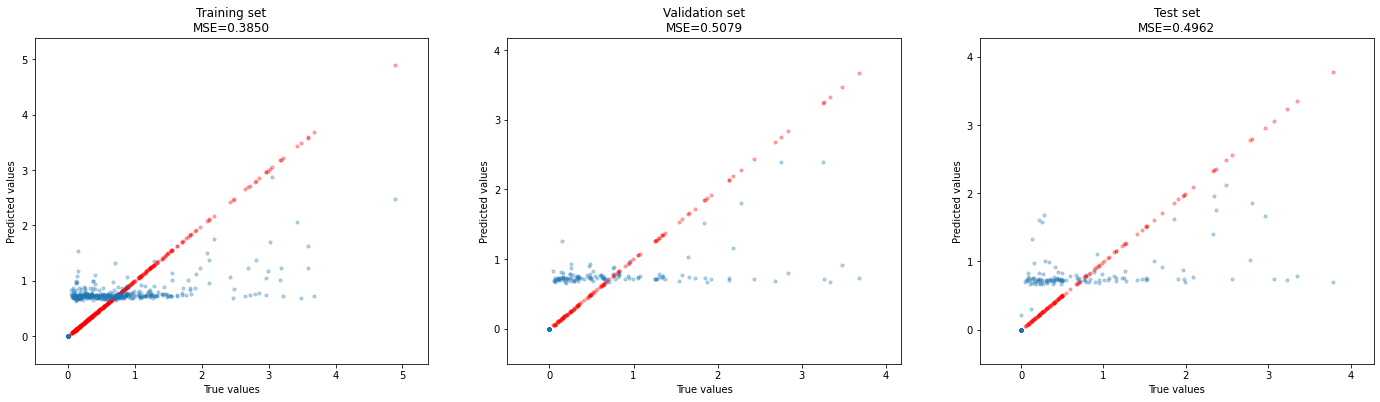

In [13]:
SAVE = False

if SAVE:
    # # Save the best model
    models[0].save(ROOT_DIR + "/best-models/two-hidden-layers-2")

if SAVE:
    plot_path=ROOT_DIR + "/best-models/two-hidden-layers-2/train-validation-test-plot.jpg"
elif SAVE == False:
    plot_path=None
    
# if not TRAINING and not CLEAN:
plot_predicted_vs_true(Xs=[X_train, X_validation, X_test],
                       Ys=[Y_train, Y_validation, Y_test],
                       model=models[0],
                       path=plot_path)

In [14]:
#https://stackoverflow.com/a/52897289/6072503

# Seed value
# Apparently you may use different seed values at each stage
seed_value=4442

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
#import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
#import tensorflow as tf
tf.random.set_seed(seed_value)

In [15]:
# Instantiate a model with the best hyperparameters -> makes the model retrainable
best_hp = tuner.get_best_hyperparameters()[0]
mode_of_best_hp = tuner.hypermodel.build(best_hp)
print(mode_of_best_hp.evaluate(X_test, Y_test))

5/5 [==============================] - ETA: 0s - loss: 1.7570 - root_mean_squared_error: 1.3255 - mean_absolute_error: 0.9595 - mean_absolute_percentage_error: 88.2270 - mean_squared_logarithmic_error: 0.52 - 0s 6ms/step - loss: 1.1527 - root_mean_squared_error: 1.0736 - mean_absolute_error: 0.6870 - mean_absolute_percentage_error: 80.4149 - mean_squared_logarithmic_error: 0.3479
[1.152713418006897, 1.0736448764801025, 0.6869577765464783, 80.4149169921875, 0.3478665351867676]


In [16]:
history = mode_of_best_hp.fit(X_train, Y_train, batch_size=96, validation_data=(X_validation, Y_validation),
          epochs=1000, verbose=0, callbacks=[early_stopping_monitor])

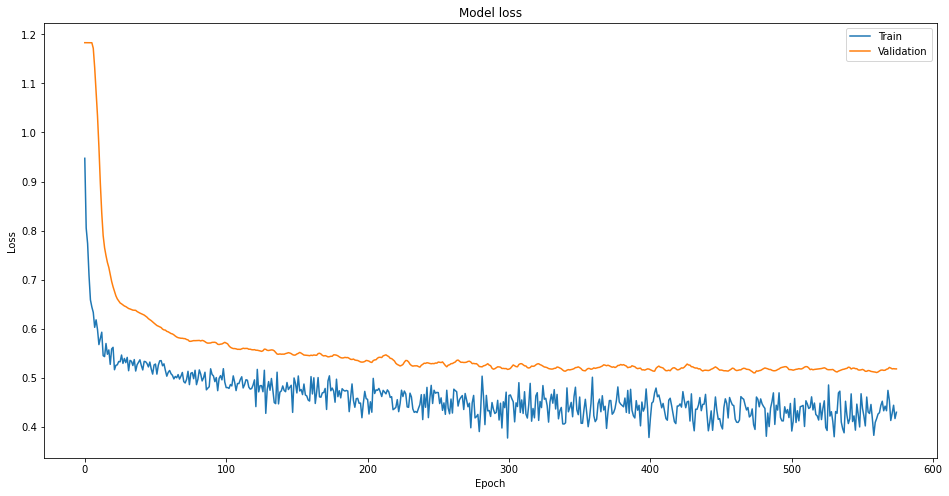

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.tight_layout()